In [21]:
import pandas as pd

df = pd.read_csv('laptop_price.csv', encoding='latin-1')
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [22]:
brand_counts = df['Company'].value_counts()
small_brands = brand_counts[brand_counts < 10].index
df['Company'] = df['Company'].apply(lambda x: "Others" if x in small_brands else x)

df['OpSys'] = df['OpSys'].replace({'Windows 10 S': 'Windows 10', 'Mac OS X': 'macOS'})
df['OpSys'] = df['OpSys'].replace(['Chrome OS', 'Android'], 'OtherSys')
df['Memory_Type'] = df['Memory'].str.extract(r'(SSD|HDD|Flash Storage)', expand=False)
import re
def convert_to_gb(value):
    unit_map = {'TB': 1024, 'GB': 1}
    match = re.search(r'(\d+)(TB|GB)', value, re.IGNORECASE)
    if match:
        num, unit = match.groups()
        return float(num) * unit_map[unit.upper()]
    return None

def trim_processor(value):
    if value.startswith('Intel'):
        return ' '.join(value.split(' ', 3)[:3])
    else:
        return ' '.join(value.split(' ', 2)[:2])
df[['Processor', 'Clock']] = df['Cpu'].apply(lambda x: pd.Series(str(x).rsplit(' ', 1)))
df['Processor'] = df['Processor'].apply(trim_processor)
cpu_counts = df['Processor'].value_counts()
rare_cpu = cpu_counts[cpu_counts < 10].index
df['Processor'] = df['Processor'].apply(lambda x: "Others" if x in rare_cpu else x)
df['Clock'] = df['Clock'].apply(lambda x: float(str(x).strip("GHz")))

df['Memory_size_GB'] = df['Memory'].apply(convert_to_gb)
df['Ram'] = df["Ram"].apply(lambda x: int(str(x).strip("GB")))
df['Weight'] = df["Weight"].apply(lambda x: float(str(x).strip("kg")))

df['Gpu_Brand'] = df['Gpu'].str.split(n=1, expand=True)[0]

df['Screen_Width'] = df['ScreenResolution'].str.rsplit(' ', n=1).str[-1].str.split('x').str[0].astype(int)
df = df.drop(['laptop_ID', 'Product', 'ScreenResolution', 'Cpu', 'Memory', 'Gpu'], axis=1)
df

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Memory_Type,Processor,Clock,Memory_size_GB,Gpu_Brand,Screen_Width
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,SSD,Intel Core i5,2.3,128.0,Intel,2560
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,Flash Storage,Intel Core i5,1.8,128.0,Intel,1440
2,HP,Notebook,15.6,8,No OS,1.86,575.00,SSD,Intel Core i5,2.5,256.0,Intel,1920
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,SSD,Intel Core i7,2.7,512.0,AMD,2880
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,SSD,Intel Core i5,3.1,256.0,Intel,2560
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14.0,4,Windows 10,1.80,638.00,SSD,Intel Core i7,2.5,128.0,Intel,1920
1299,Lenovo,2 in 1 Convertible,13.3,16,Windows 10,1.30,1499.00,SSD,Intel Core i7,2.5,512.0,Intel,3200
1300,Lenovo,Notebook,14.0,2,Windows 10,1.50,229.00,Flash Storage,Intel Celeron Dual,1.6,64.0,Intel,1366
1301,HP,Notebook,15.6,6,Windows 10,2.19,764.00,HDD,Intel Core i7,2.5,1024.0,AMD,1366


Pojawiają się wartości odstające, ale są to wartości realne. Nie jest więc uzasadnione pozbywanie się ich.

**Czyszczenie danych**

In [23]:
any_nan = df.isnull().values.any()
any_nan

True

In [24]:
df.dropna()
df.drop_duplicates(keep='first', inplace=True)

def remove_outliers(df, columns):
    indices_to_remove = set()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        indices_to_remove.update(outliers_indices)

    df_cleaned = df.drop(indices_to_remove)

    return df_cleaned
df = remove_outliers(df, ['Price_euros', "Inches"])
df

,Company,TypeName,Inches,Ram,OpSys,Weight,Price_euros,Memory_Type,Processor,Clock,Memory_size_GB,Gpu_Brand,Screen_Width
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,SSD,Intel Core i5,2.3,128.0,Intel,2560
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,Flash Storage,Intel Core i5,1.8,128.0,Intel,1440
2,HP,Notebook,15.6,8,No OS,1.86,575.00,SSD,Intel Core i5,2.5,256.0,Intel,1920
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,SSD,Intel Core i7,2.7,512.0,AMD,2880
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,SSD,Intel Core i5,3.1,256.0,Intel,2560
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Asus,Notebook,15.6,4,Windows 10,2.20,720.32,HDD,Intel Core i7,2.5,500.0,Nvidia,1366
1270,Lenovo,2 in 1 Convertible,14.0,4,Windows 10,1.80,638.00,SSD,Intel Core i7,2.5,128.0,Intel,1920
1271,Lenovo,2 in 1 Convertible,13.3,16,Windows 10,1.30,1499.00,SSD,Intel Core i7,2.5,512.0,Intel,3200
1272,Lenovo,Notebook,14.0,2,Windows 10,1.50,229.00,Flash Storage,Intel Celeron Dual,1.6,64.0,Intel,1366


**Hot One Encoding**

In [25]:
from sklearn.model_selection import train_test_split

X = df.drop('Price_euros', axis=1)
y = df['Price_euros']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [26]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
df_encoded = df.copy()
columns_to_encode=['Company','TypeName', 'OpSys', 'Memory_Type', 'Gpu_Brand', "Processor"]
encoder.fit(X_train[columns_to_encode])

X_train_encoded = encoder.transform(X_train[columns_to_encode])
X_test_encoded = encoder.transform(X_test[columns_to_encode])

X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode), index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=encoder.get_feature_names_out(columns_to_encode), index=X_test.index)

X_train_dropped = X_train.drop(columns=columns_to_encode)
X_test_dropped = X_test.drop(columns=columns_to_encode)

X_train_final = pd.concat([X_train_dropped, X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test_dropped, X_test_encoded_df], axis=1)

In [27]:
X_train_final.dtypes

Inches                          float64
Ram                               int64
Weight                          float64
Clock                           float64
Memory_size_GB                  float64
Screen_Width                      int32
Company_Acer                    float64
Company_Apple                   float64
Company_Asus                    float64
Company_Dell                    float64
Company_HP                      float64
Company_Lenovo                  float64
Company_MSI                     float64
Company_Others                  float64
Company_Toshiba                 float64
TypeName_2 in 1 Convertible     float64
TypeName_Gaming                 float64
TypeName_Netbook                float64
TypeName_Notebook               float64
TypeName_Ultrabook              float64
TypeName_Workstation            float64
OpSys_Linux                     float64
OpSys_No OS                     float64
OpSys_OtherSys                  float64
OpSys_Windows 10                float64


**Normalizacja zmiennych**

In [28]:
mean_values = X_train_final.mean()
std_values = X_train_final.std()

print("Średnie wartości dla każdej kolumny:\n", mean_values)
print("\nOdchylenia standardowe dla każdej kolumny:\n", std_values)

Średnie wartości dla każdej kolumny:
 Inches                            15.081799
Ram                                8.237849
Weight                             2.026140
Clock                              2.313382
Memory_size_GB                   456.000000
Screen_Width                    1900.004137
Company_Acer                       0.070321
Company_Apple                      0.013444
Company_Asus                       0.109617
Company_Dell                       0.239917
Company_HP                         0.209928
Company_Lenovo                     0.230610
Company_MSI                        0.045502
Company_Others                     0.039297
Company_Toshiba                    0.041365
TypeName_2 in 1 Convertible        0.089969
TypeName_Gaming                    0.150982
TypeName_Netbook                   0.006205
TypeName_Notebook                  0.580145
TypeName_Ultrabook                 0.154085
TypeName_Workstation               0.018614
OpSys_Linux                        0.0

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_final)
X_train_scaled = scaler.transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns, index=X_train_final.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_final.columns, index=X_test_final.index)

mean_values = X_train_scaled_df.mean()
std_values = X_train_scaled_df.std()
print("Średnie wartości dla każdej kolumny:\n", mean_values)
print("\nOdchylenia standardowe dla każdej kolumny:\n", std_values)

Średnie wartości dla każdej kolumny:
 Inches                          1.418146e-15
Ram                             1.102186e-16
Weight                          4.592443e-16
Clock                           1.901271e-16
Memory_size_GB                  6.796815e-17
Screen_Width                   -1.028707e-16
Company_Acer                    2.939163e-17
Company_Apple                  -2.204372e-17
Company_Asus                   -7.347908e-18
Company_Dell                   -2.663617e-17
Company_HP                     -1.065447e-16
Company_Lenovo                 -2.939163e-17
Company_MSI                     6.613117e-17
Company_Others                  9.276734e-17
Company_Toshiba                -1.120556e-16
TypeName_2 in 1 Convertible    -2.939163e-17
TypeName_Gaming                -3.673954e-17
TypeName_Netbook               -3.673954e-18
TypeName_Notebook               5.051687e-17
TypeName_Ultrabook             -4.133198e-17
TypeName_Workstation            1.102186e-17
OpSys_Linux      

**Regresja wielomianowa**

In [34]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled_df, y_train)
y_pred_linear = linear_model.predict(X_test_scaled_df)
print(f'Współczynniki: {linear_model.coef_}')

Współczynniki: [-4.00323661e+01  1.95609274e+02  7.19587674e+01  7.26636037e+01
  4.75698670e+00  9.24389065e+01 -2.27431091e+14 -2.22687017e+15
 -2.77888159e+14 -3.79842185e+14 -3.62251532e+14 -3.74674755e+14
 -1.85371397e+14 -1.72828431e+14 -1.77127256e+14 -3.18253150e+14
 -3.98216962e+14 -8.73391715e+13 -5.48929026e+14 -4.01551761e+14
 -1.50328425e+14 -2.85798990e+15 -3.19556088e+15 -1.30284569e+15
 -4.97774719e+15 -2.39005417e+15  5.61878811e+14 -7.93638380e+14
 -1.93926543e+15 -2.01172232e+15 -3.60217925e+14  2.14793031e+15
  2.04393578e+14  3.15783548e+15  2.93901977e+15 -4.82695158e+14
 -6.51869876e+14 -1.13218111e+15 -5.90254943e+14 -1.95174186e+15
 -2.94846655e+15 -3.01547570e+15 -8.53132708e+14 -1.23860562e+15]


In [35]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled_df, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled_df)
print(f'Współczynniki: {lasso_model.coef_}')


Współczynniki: [-34.24001356 192.60836004  66.35293674  73.14633402   0.
  92.31310653 -32.71782338   9.26434021 -25.92668211 -11.8818004
   8.92458624   0.          30.65083795  -0.          22.96688709
  18.09922993 -18.54196465  18.02819844 -89.23008809  45.20158436
  65.32611954 -24.36489078 -50.06855262  -0.           0.
  37.71762841   0.87513898   0.          -3.20124126  71.06171939
 -11.50391034 -20.89473636  -2.37461192  31.42738969  -0.
 -23.63099882 -21.66637782 -24.61081546  11.69504446 -47.78660268
   0.          52.16082182  -9.5090131  -41.43092677]


In [36]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled_df, y_train)
y_pred_ridge = ridge_model.predict(X_test_scaled_df)
print(f'Współczynniki: {ridge_model.coef_}')


Współczynniki: [-39.94985869 190.70342413  77.15488532  73.60898269   4.54330981
  92.6981888  -32.00116396   7.5039796  -23.52672809 -10.1527644
  12.6061455    2.83968309  35.35973805   1.1270077   25.53868787
  28.39654226 -11.87441567  20.97991517 -73.07341881  58.2833439
  70.29460705 -17.52987352 -42.49677597   3.72852346  12.80538395
  44.17314686   7.5039796  -10.06469992 -35.66663925  41.51873235
 -17.68192928 -25.84744775  -4.03013337  24.77700471  -7.45127848
 -23.79486327 -21.41979184 -23.53718181  13.30377344 -45.23553879
   5.53434091  57.81881758  -9.41082794 -40.45513864]


In [37]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3)
X_train_poly = poly_features.fit_transform(X_train_scaled_df)
X_test_poly = poly_features.transform(X_test_scaled_df)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)
print(f'Współczynniki: {poly_model.coef_}')



Współczynniki: [-2.24993014e+09 -6.38658853e+09  4.36208543e+08 ...  6.72952466e+09
  1.95963846e+09 -1.80288480e+09]


In [38]:
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_scaled_df, y_train)
y_pred_tree = tree_model.predict(X_test_scaled_df)


IndexError: index 18 is out of bounds for axis 0 with size 12

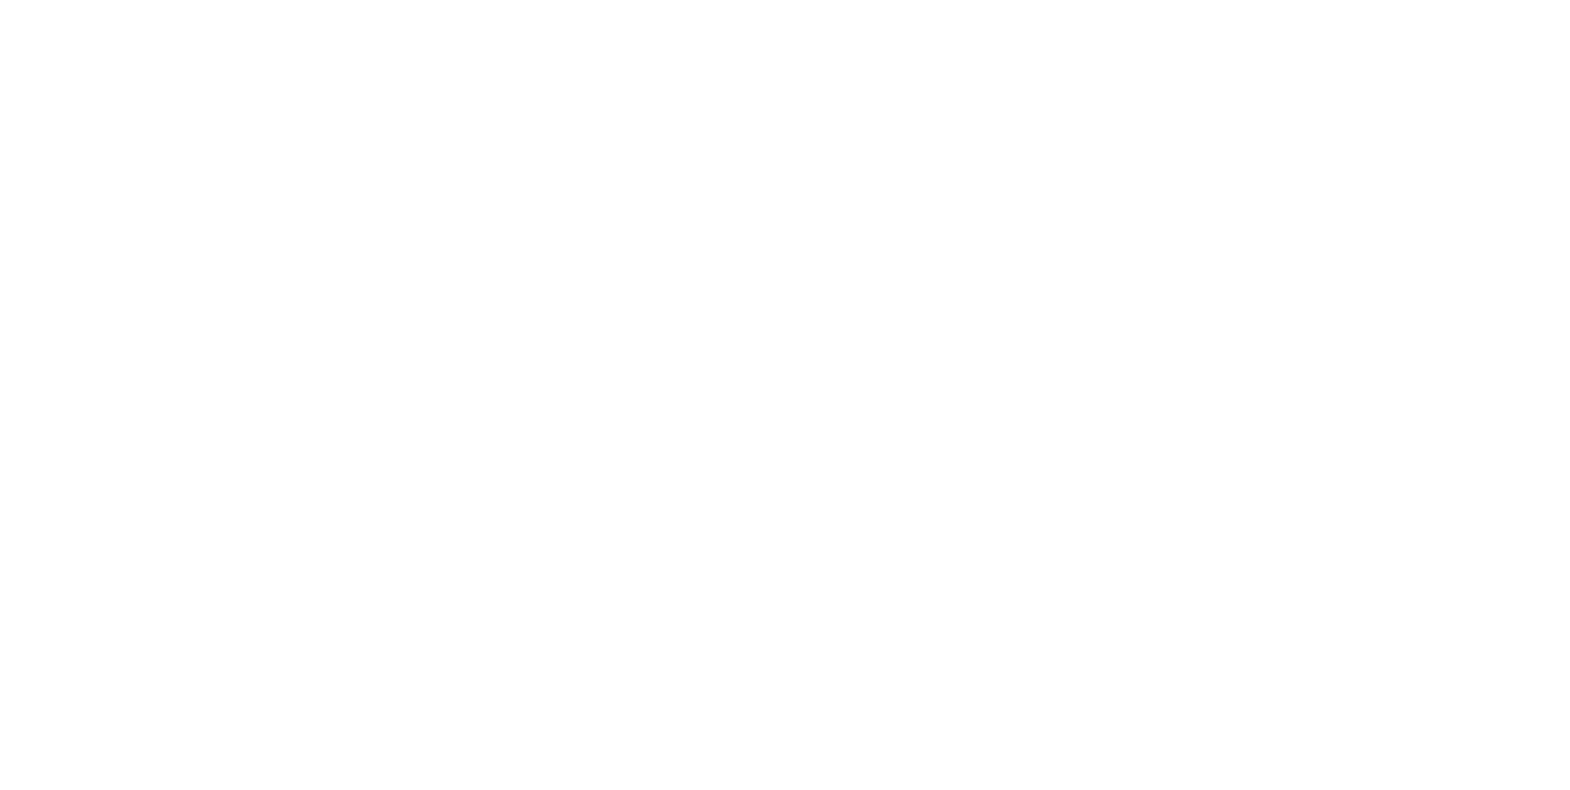

In [39]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(tree_model, filled=True, feature_names=X.columns, max_depth=3, fontsize=10)
plt.show()


In [40]:
from sklearn.metrics import r2_score, mean_squared_error
model_names = ['Linear', 'Lasso', 'Ridge', 'Polynomial', 'Decision Tree']
predictions = [y_pred_linear, y_pred_lasso, y_pred_ridge, y_pred_poly, y_pred_tree]
results = []

for model_name, pred in zip(model_names, predictions):
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    results.append({"Model": model_name, "MSE": mse, "R2": r2})

results_df = pd.DataFrame(results)

In [41]:
results_df

,Model,MSE,R2
0,Linear,8.040305e+04,7.801041e-01
1,Lasso,8.033958e+04,7.802777e-01
2,Ridge,8.045781e+04,7.799544e-01
3,Polynomial,8.043261e+24,-2.199767e+19
4,Decision Tree,1.116344e+05,6.946890e-01
